<h1><center>Multi-Period Demand Response Management</center></h1>


# 1. Stackelberg Game 
Let $\scr{K}=\{1,2,\dots,K\}$ be the set of companies, $\scr{N}=\{1,2,\dots,N\}$ be the set of consumers, and $\scr{T}=\{1,2,\dots,T\}$ be the finite set of time slots.

We formulate a static Stackelberg game between companies (the leaders) and their consumers (the followers) to find revenue maximizing prices and optimal demands. In Stackelberg games, the leader(s) first announce their decisions to the follower(s), and then the followers respond. In our game, the leaders send price signals to the consumers, who respond optimally by choosing their demands. To capture the  market competition between the companies, we let them play a price-selection Nash game. The equilibrium point of the price-selection game is what companies announce to their consumers.




## 1.1 Consumer-Side 

Each energy consumer $n\in \scr{N}$ receives all price signals from each company $k\in \scr{K}$ at each time slot $t\in \scr{T}$ and aims to select his corresponding utility-maximizing demand $d_{n,k}(t)\geq0$ for each time slot from each company, subject to budget and energy need constraints. Denote company $k$'s price at time $t$ by $p_k(t)$. Let $B_n \geq 0$  and $E^{{\rm min}}_n \geq 0$ denote, respectively, consumer $n$'s budget and minimum energy need for the entire time-horizon. The utility of consumer $n$ is defined as 
$$ U_{{\rm consumer},n}=\gamma_n\sum_{k\in \scr{K}}\sum_{t\in \scr{T}}\ln(\zeta_n+d_{n,k}(t))$$
where $\gamma_n$ and $\zeta_n\geq1$ are consumer specific parameters. Consumer $n$ aims to achieve the highest payoff while meeting the threshold of minimum amount of energy and not exceeding a certain budget. To be more precise,
given $B_n \geq 0$, $E^{{\rm min}}_n \geq 0$, and $p_k(t)>0$, the consumer-side optimization problem is formulated as follows:

\begin{eqnarray}&{\text{maximize}}   \ \ \ \ \ & U_{{\rm consumer},n}, \\
 &\text{subject to} &   \ \sum_{k\in \scr{K}}\sum_{t\in \scr{T}}p_k(t)d_{n,k}(t)\leq B_n \\
&&\sum_{k\in \scr{K}}\sum_{t\in \scr{T}}d_{n,k}(t)\geq \,E^{{\rm min}}_n, \\
&& d_{n,k}(t)\geq 0,\;\;   \\
&& \text{for each } \ t \in \scr{T}, \ k \in \scr{K} \end{eqnarray}

For the remaining of this notebook, we let $\zeta_n=\gamma_n=1$ for each $n$.

## 1.2 Company-Side 

Letting ${\bf{p_{-k}}}$ denote the prices set by other companies, the total revenue for company $k$ is given by

$$U_{{\rm company},k}=\sum_{t\in \scr{T}}p_k(t)\sum_{n\in \scr{N}}d_{n,k}(p_k,{\bf{p_{-k}}},t).$$

Given the power availability of UC $k$ at period $t$, denoted by $G_k(t)$, and for a fixed ${\bf{p_{-k}}}$, company $k$'s problem is


\begin{eqnarray}&{\text{maximize}}   \ \ \ \ \ & U_{{\rm company},k} (p_k,{\bf{p_{-k}}}), \\
&\text{subject to} &   \ \sum_{n\in \scr{N}} d_{n,k}(p_k,{\bf{p_{-k}}},t) \leq G_k(t) \\
&& p_k(t)> 0, \\
&& \text{for each } \ t \in \scr{T}. \end{eqnarray}

  The goal of each company is to maximize its revenue and hence maximize its profit. Additionally, because of the market competition, the prices announced by other companies also affect the determination of the price at company $k$. Thus, company $k$'s price selection is actually a response to what other competitors in the market have announced; this response is also constrained by the availability of power. Thus, what we have is a Nash game among the utility companies.

<b> In this notebook, we numerically implement the closed-form solutions and algorithm discussed in [Alshehri et. al.] for various scenarios.

In [1]:
#Calling the necessary libraries 

import numpy as np 
import scipy.io
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline


<b>Now, we define the optimal demand functions $d^*_{n,k}(t)$ and prices $p^*_{k}(t)$, and other necessary functions. <b>

In [2]:
# In this cell, we only define the functions 

# Denote the number of consumers by N, the number of utility companies by K, and the number of periods by T. 
# We take \zeta_n's and \gamma_n's to be 1 for all consumers 

def d(n,k,t):
    
    y=(B[n-1]+np.sum(P))/(K*T*P[k-1,t-1])-1    
    
    return y

def p(k,t):
    
    y=(np.sum(B)/(G[k-1,t-1]+N))*(1/(K*T-np.sum(N/(G+N))))   
    
    return y

def Un(n):
    
    demand=np.zeros((K,T))
    for i in range(T):
        for j in range(K):
            demand[j,i]=d(n,j,i)
    
    y=np.sum(np.log(1+demand))
    
    return y

def Uk(k):
    
    demand=np.zeros((N,T))
    for i in range(T):
        for j in range(N):
            demand[j,i]=d(j,k,i)

    demand_t=np.zeros(T)
    for i in range(T):
        demand_t[i]=np.sum(demand[:,i])

    y=np.dot(P[k-1,:],demand_t)

    return y

## 2. Case Study: EcoGrid EU

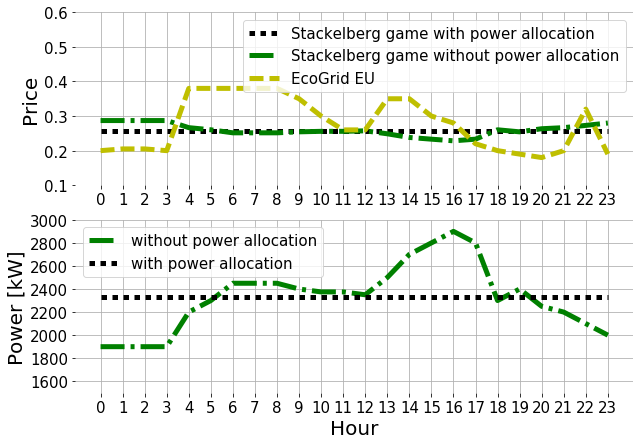

In [3]:
T,N,K=24,2000,1
B,G,P,P_Eco,P_NE=np.zeros(N),np.zeros((K,T)),np.zeros((K,T)),np.zeros((K,T)),np.zeros((K,T))


# Flexible Power from EcoGrid 

G=([1900,1900,1900,1900,2200,2300,2450,2450,2450,2400,2375,2375,2350,2500,2700,2800,2900,2800,2300,2400,2250,2200,2100,2000])
G=np.reshape(G,(K,T))

# Prices from EcoGrid  (converted to DKK/kWh)
P_Eco=([200,205,205,200,380,380,380,380,380,350,300,260,260,350,350,300,280,220,200,190,180,200,320,190])
P_Eco=np.reshape(P_Eco,(K,T))/1000

E_total=np.sum(G)

# Find necessary budgets from Theorem 1
B[0:N]=(((E_total+K*T)/np.sum(1/(K*T*P_Eco)))-np.sum(P_Eco))/N


# Optimal Prices 
for t in range(T):
    for k in range(K):
        P[k,t]=p(k+1,t+1)

G[0:T]=E_total/T

# Optimal Prices at NE of power allocation
for t in range(T):
    for k in range(K):
        P_NE[k,t]=p(k+1,t+1)


# Visualizing prices
plt.figure(figsize=(10, 7))    
ax = plt.subplot(211)

ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(False)    
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(False)    
  
ax.get_xaxis().tick_bottom()    
ax.get_yaxis().tick_left()    

plt.ylim(0.1,0.6)
plt.xticks(np.arange(0, T, 1))
plt.xticks(fontsize=15)    
plt.yticks(fontsize=15)    
  

plt.plot(P_NE[0,:],':',color='k',label='Stackelberg game with power allocation',linewidth=5)
plt.plot(P[0,:],'-.',color='g',label='Stackelberg game without power allocation',linewidth=5)
plt.plot(P_Eco[0,:],'--',color='y',label='EcoGrid EU',linewidth=5)
plt.grid(True)    
plt.ylabel('Price',fontsize=20)
plt.legend(fontsize=15,loc='best')


# Visualizing power
ax = plt.subplot(212)

ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(False)    
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(False)    
  
ax.get_xaxis().tick_bottom()    
ax.get_yaxis().tick_left()    

plt.ylim(1500,3000)
plt.xticks(np.arange(0, T, 1))
plt.xticks(fontsize=15)    
plt.yticks(fontsize=15)    
  


G=([1900,1900,1900,1900,2200,2300,2450,2450,2450,2400,2375,2375,2350,2500,2700,2800,2900,2800,2300,2400,2250,2200,2100,2000])
E_total=np.sum(G)
G=np.reshape(G,(K,T))
G_NE=np.zeros((K,T))
G_NE[0:T]=E_total/T

plt.plot(G[0,:],'-.',color='g',label='without power allocation',linewidth=5)
plt.plot(G_NE[0,:],':',color='k',label='with power allocation',linewidth=5)
plt.grid(True)    
plt.ylabel('Power [kW]',fontsize=20)
plt.xlabel('Hour',fontsize=20)
plt.legend(fontsize=15,loc='upper left')


plt.savefig('EcoGridEU_Price_Power.pdf')


## 2.1 Influence of the Number of Periods

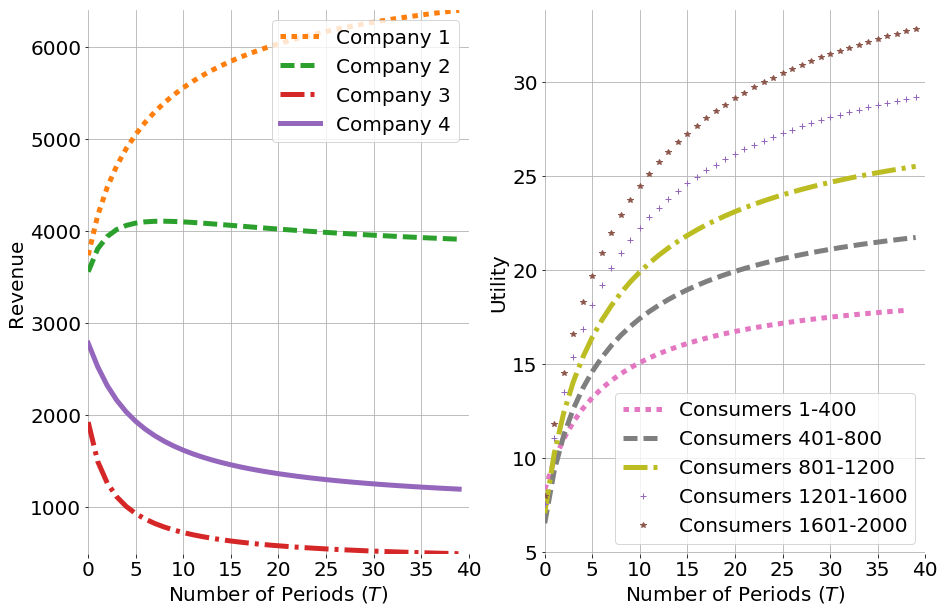

In [4]:

N=2000
K=4
B=np.zeros(N)
Max_T=40
Utility=np.zeros((Max_T,N))
Revenue=np.zeros((Max_T,K))
E_total=np.sum(([1900,1900,1900,1900,2200,2300,2450,2450,2450,2400,2375,2375,2350,2500,2700,2800,2900,2800,2300,2400,2250,2200,2100,2000]))

for i in range(Max_T):
    T=i+1
    G=np.zeros((K,T))
    P=np.zeros((K,T))
    B[0:400],B[400:800],B[800:1200],B[1200:1600],B[1600:2000]=4,5,6,7,8
    G[0,:],G[1,:],G[2,:],G[3,:]=(36/59)*E_total/T,(16/50)*E_total/T,(2/59)*E_total/T,(5/59)*E_total/T
    for t in range(T):
        for k in range(K):
            P[k,t]=p(k+1,t+1)
    
    for k in range(K):
        Revenue[i,k]=Uk(k+1)
    
    for n in range(N):
        Utility[i,n]=Un(n+1)
 
# Visualizing revenues

plt.figure(figsize=(15, 10))    
  
# Remove the plot frame lines.  
ax = plt.subplot(121)    
ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(False)    
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(False)    
  
# Ensure that the axis ticks only show up on the bottom and left of the plot.    
ax.get_xaxis().tick_bottom()    
ax.get_yaxis().tick_left()    
  
# Limit the range of the plot to only where the data is.    
# Avoid unnecessary whitespace.    
plt.ylim(np.min(Revenue)-1, np.max(Revenue)+1)
plt.xlim(0,Max_T)    
  
# # Make sure your axis ticks are large enough to be easily read.    
plt.xticks(fontsize=20)    
plt.yticks(fontsize=20)    
  

        
plt.plot(Revenue[:,0],':',color='C%s'%(1),label='Company 1',linewidth=5)
plt.plot(Revenue[:,1],'--',color='C%s'%(2),label='Company 2',linewidth=5)
plt.plot(Revenue[:,2],'-.',color='C%s'%(3),label='Company 3',linewidth=5)
plt.plot(Revenue[:,3],color='C%s'%(4),label='Company 4',linewidth=5)
plt.grid(True)    
plt.ylabel('Revenue',fontsize=20)
plt.xlabel('Number of Periods ($T$)',fontsize=20)
plt.legend(fontsize=20,loc='best')


# Visualizing utilities

ax = plt.subplot(122)

ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(False)    
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(False)    
  
ax.get_xaxis().tick_bottom()    
ax.get_yaxis().tick_left()    

plt.ylim(np.min(Utility)-1, np.max(Utility)+1)
plt.xlim(0,Max_T)    
  
plt.xticks(fontsize=20)    
plt.yticks(fontsize=20)    
  

        
plt.plot(Utility[1:T,0],':',color='C%s'%(6),label='Consumers 1-400',linewidth=5)
plt.plot(Utility[:,401],'--',color='C%s'%(7),label='Consumers 401-800',linewidth=5)
plt.plot(Utility[:,801],'-.',color='C%s'%(8),label='Consumers 801-1200',linewidth=5)
plt.plot(Utility[:,1201],'+',color='C%s'%(4),label='Consumers 1201-1600',linewidth=5)
plt.plot(Utility[:,1601],'*',color='C%s'%(5),label='Consumers 1601-2000',linewidth=5)

plt.grid(True)    
plt.ylabel('Utility',fontsize=20)
plt.xlabel('Number of Periods ($T$)',fontsize=20)
plt.legend(fontsize=20,loc='lower right')


plt.savefig('Influence_of_T.pdf')



### 2.2 Distributed Algorithm

For each iteration $i\in\{0,1,\ldots\}$, denote the demand from user $n$ at time $t$ from company $k$ by $d^{(i)}_{n,k}(t)$, and the price announced by company $k$ and time $t$ by $p^{(i)}_k(t)$. In our algorithm,  $p^{(1)}_k(t)$ is chosen arbitrarily for each company $k\in \scr{K}$ and time $t\in\scr{T}$. Based on the initial price selection, $d^{(1)}_{n,k}$'s are computed. Then, the prices are sequentially updated using the following update rule: 
$$p^{(i+1)}_k(t)=p^{(i)}_k(t)+\frac{\sum_{n\in \scr{N}}d^{(i)}_{n,k}(t)-G_k(t)}{\epsilon^{(i)}_{k,t}},$$
where $\epsilon^{(i)}_{k,t}>0$ is $$ \epsilon^{(i)}_{k,t} =  \frac{G_k(t)+N}{p^{(i)}_k(t)} + \delta,$$
where $\delta\geq0$.


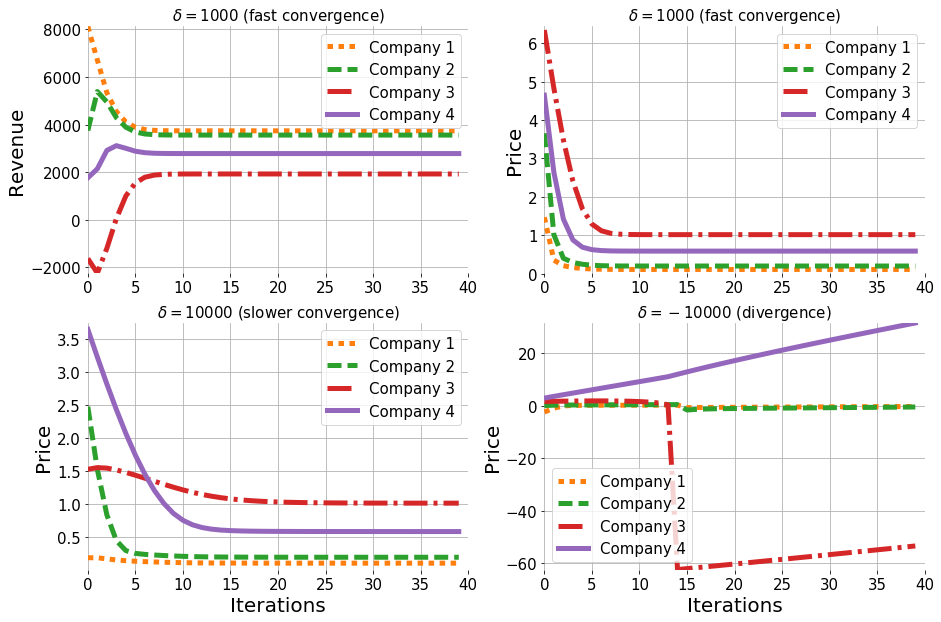

In [9]:

T,N,K=1,2000,4
B,G=np.zeros(N),np.zeros((K,T))
B[0:400],B[400:800],B[800:1200],B[1200:1600],B[1600:2000]=4,5,6,7,8


G[0,:],G[1,:],G[2,:],G[3,:]=(36/59)*E_total/T,(16/50)*E_total/T,(2/59)*E_total/T,(5/59)*E_total/T

Max_iter=40
P,demand=np.random.rand(K,T)*10,np.zeros((N))

#Logging prices for each iteration for each company
P_iter_1,P_iter_2,P_iter_3,P_iter_4=np.ones(Max_iter),np.ones(Max_iter),np.ones(Max_iter),np.ones(Max_iter)

# computing the prices with delta=100. 

delta=1000
for i in range(Max_iter):
    for t in range(T):
        for k in range(K):
            for n in range(N):
                demand[n]=d(n+1,k+1,t+1)
            epsilon=(G[k,t]+N)/P[k,t]+delta
            P[k,t]=P[k,t]+(np.sum(demand)-G[k,t])/epsilon
    P_iter_1[i]=P[0,0]
    P_iter_2[i]=P[1,0]
    P_iter_3[i]=P[2,0]
    P_iter_4[i]=P[3,0]

    
# Visualizing the outcomes

Revenue=np.zeros((Max_iter,K))
for i in range(Max_iter):
    
    P[0,0],P[1,0],P[2,0],P[3,0]=P_iter_1[i],P_iter_2[i],P_iter_3[i],P_iter_4[i]
    
    Revenue[i,0]=Uk(1)
    Revenue[i,1]=Uk(2)
    Revenue[i,2]=Uk(3)
    Revenue[i,3]=Uk(4)

plt.figure(figsize=(15, 10))    

# plotting the revenues
  
ax = plt.subplot(221)    
ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(False)    
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(False)    
  
ax.get_xaxis().tick_bottom()    
ax.get_yaxis().tick_left()    
  
plt.ylim(np.min(Revenue)-10, np.max(Revenue)+10)
plt.xlim(0,Max_iter,1)    
  
plt.xticks(fontsize=15)    
plt.yticks(fontsize=15)    
  

plt.plot(Revenue[:,0],':',color='C%s'%(1),label='Company 1',linewidth=5)
plt.plot(Revenue[:,1],'--',color='C%s'%(2),label='Company 2',linewidth=5)
plt.plot(Revenue[:,2],'-.',color='C%s'%(3),label='Company 3',linewidth=5)
plt.plot(Revenue[:,3],color='C%s'%(4),label='Company 4',linewidth=5)
plt.grid(True)    
plt.ylabel('Revenue',fontsize=20)
plt.title('$\delta=1000$ (fast convergence)',fontsize=15)
plt.legend(fontsize=15,loc='best')


# plotting the prices

ax = plt.subplot(222)

ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(False)    
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(False)    
  
ax.get_xaxis().tick_bottom()    
ax.get_yaxis().tick_left()    

plt.ylim(np.min([P_iter_1,P_iter_2,P_iter_3,P_iter_4])-0.1,np.max([P_iter_1,P_iter_2,P_iter_3,P_iter_4])+0.1)
plt.xlim(0,Max_iter,1)  
plt.xticks(fontsize=15)    
plt.yticks(fontsize=15)    

        
plt.plot(P_iter_1[:],':',color='C%s'%(1),label='Company 1',linewidth=5)
plt.plot(P_iter_2[:],'--',color='C%s'%(2),label='Company 2',linewidth=5)
plt.plot(P_iter_3[:],'-.',color='C%s'%(3),label='Company 3',linewidth=5)
plt.plot(P_iter_4[:],color='C%s'%(4),label='Company 4',linewidth=5)
plt.grid(True)    
plt.ylabel('Price',fontsize=20)
plt.title('$\delta=1000$ (fast convergence)',fontsize=15)
plt.legend(fontsize=15,loc='best')



# Increase delta to 10000 

P,demand=np.random.rand(K,T)*5,np.zeros((N))
delta=10000
for i in range(Max_iter):
    for t in range(T):
        for k in range(K):
            for n in range(N):
                demand[n]=d(n+1,k+1,t+1)
            epsilon=(G[k,t]+N)/P[k,t]+delta
            P[k,t]=P[k,t]+(np.sum(demand)-G[k,t])/epsilon
    P_iter_1[i]=P[0,0]
    P_iter_2[i]=P[1,0]
    P_iter_3[i]=P[2,0]
    P_iter_4[i]=P[3,0]


# Plot the prices 

ax = plt.subplot(223)

ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(False)    
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(False)    
  
ax.get_xaxis().tick_bottom()    
ax.get_yaxis().tick_left()    

plt.ylim(np.min([P_iter_1,P_iter_2,P_iter_3,P_iter_4])-0.1,np.max([P_iter_1,P_iter_2,P_iter_3,P_iter_4])+0.1)
plt.xlim(0,Max_iter,1)  
plt.xticks(fontsize=15)    
plt.yticks(fontsize=15)    
  

        
plt.plot(P_iter_1[:],':',color='C%s'%(1),label='Company 1',linewidth=5)
plt.plot(P_iter_2[:],'--',color='C%s'%(2),label='Company 2',linewidth=5)
plt.plot(P_iter_3[:],'-.',color='C%s'%(3),label='Company 3',linewidth=5)
plt.plot(P_iter_4[:],color='C%s'%(4),label='Company 4',linewidth=5)

plt.grid(True)    
plt.ylabel('Price',fontsize=20)
plt.xlabel('Iterations',fontsize=20)
plt.legend(fontsize=15,loc='best')
plt.title('$\delta=10000$ (slower convergence)',fontsize=15)


# Divergence 

P,demand=np.random.rand(K,T)*5,np.zeros((N))
delta=-10000
for i in range(Max_iter):
    for t in range(T):
        for k in range(K):
            for n in range(N):
                demand[n]=d(n+1,k+1,t+1)
            epsilon=(G[k,t]+N)/P[k,t]+delta
            P[k,t]=P[k,t]+(np.sum(demand)-G[k,t])/epsilon
    P_iter_1[i]=P[0,0]
    P_iter_2[i]=P[1,0]
    P_iter_3[i]=P[2,0]
    P_iter_4[i]=P[3,0]


ax = plt.subplot(224)

ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(False)    
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(False)    
  
ax.get_xaxis().tick_bottom()    
ax.get_yaxis().tick_left()    

plt.ylim(np.min([P_iter_1,P_iter_2,P_iter_3,P_iter_4])-0.1,np.max([P_iter_1,P_iter_2,P_iter_3,P_iter_4])+0.1)
plt.xlim(0,Max_iter,1)  
plt.xticks(fontsize=15)    
plt.yticks(fontsize=15)    
  

        
plt.plot(P_iter_1[:],':',color='C%s'%(1),label='Company 1',linewidth=5)
plt.plot(P_iter_2[:],'--',color='C%s'%(2),label='Company 2',linewidth=5)
plt.plot(P_iter_3[:],'-.',color='C%s'%(3),label='Company 3',linewidth=5)
plt.plot(P_iter_4[:],color='C%s'%(4),label='Company 4',linewidth=5)

plt.grid(True)    
plt.ylabel('Price',fontsize=20)
plt.xlabel('Iterations',fontsize=20)
plt.legend(fontsize=15,loc='best')
plt.title('$\delta=-10000$ (divergence)',fontsize=15)

plt.savefig('algorithm.pdf')


##### References 
K. Alshehri, J. Liu, X. Chen, and T. Başar. A Stackelberg game for multi-period demand response management in the smart grid. Proc. 54th IEEE Conference on Decision and Control (CDC'15, Dec 15-18, 2015; Osaka, Japan), pp. 5889-5894.


K. Alshehri, J. Liu, X. Chen, and T. Başar. A Game-Theoretic Method for Multi-Period Demand Response: Revenue Maximization, Power Allocation, and Asymptotic Behavior. https://arxiv.org/abs/1710.00145

